<a href="https://colab.research.google.com/github/sinheechan/CAM_Binary-classifier/blob/main/Find_a_Car_Park_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAM(Class Activation Map)



## 1. Setting

In [ ]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

## 2. Data Introduce

본 과정에서 데이터로 Kaggle의 Find a Car Park 데이터셋을 활용합니다.

해당 데이터셋은 지역의 특정 지리적 공간 반경 내에 있는 경우 여유 공간이 있는지 여부를 식별하고

사용자에게 메시지를 보내는 데 사용되는 주차장 공간의 이미지 파일이 내장되어 있습니다.

이미지는 무료 또는 전체로 분류됩니다. 이미지 해상도는 각각 1296 x 972픽셀입니다.

이를 통해 주차장 내 주차공간의 유무를 판단하는 모델을 구현합니다.

In [ ]:
# Dataset - https://www.kaggle.com/datasets/daggysheep/find-a-car-park
os.environ['KAGGLE_USERNAME'] = 'leelang' # username
os.environ['KAGGLE_KEY'] = 'ed40ce9827535f3e8ea9b08699651eab' # key
!kaggle datasets download -d phylake1337/fire-dataset

100% 387M/387M [00:10<00:00, 35.2MB/s]
100% 387M/387M [00:10<00:00, 39.7MB/s]


In [ ]:
!unzip -q fire-dataset.zip

755
244


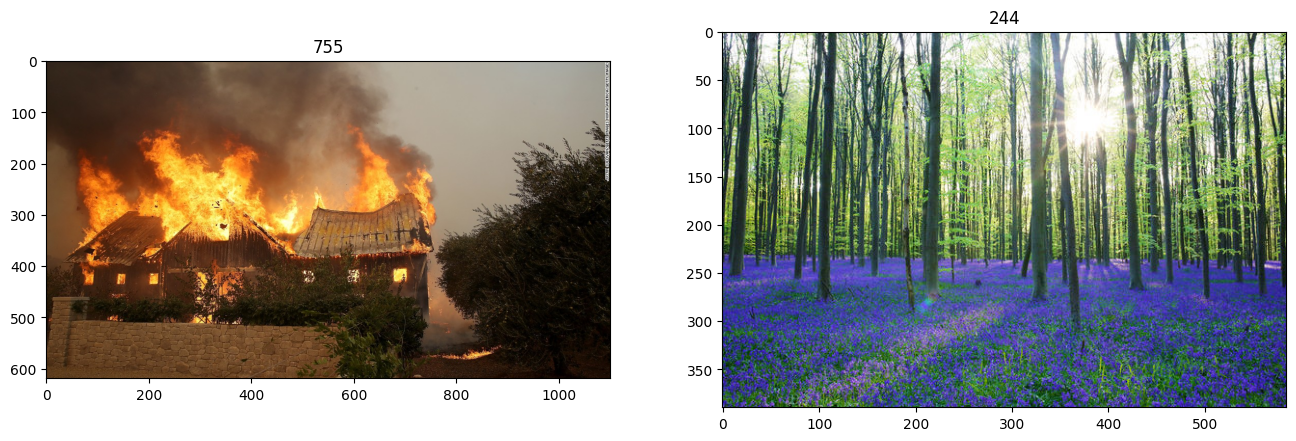

In [ ]:
# Preview Dataset
BASE_PATH = 'fire_dataset'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.png'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.png'))
print(len(full_list)) # 2095장
print(len(free_list)) # 1067장

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

In [ ]:
# DataGenerator
# 어그멘테이션
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 900 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


In [ ]:
# Load Model for Transfer Learning
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False) #1000이미지 분류 모델

x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 피기
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

In [ ]:
# Switch Layers to be Trainable # 레이어 웨이트 변경 방지
for layer in model.layers:
    layer.trainable = True

In [ ]:
# Train
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.h5', monitor='val_acc', save_best_only=True, verbose=1)
    ]
)

<ipython-input-32-fe71b4a2412f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 0.2082 - acc: 0.9178
Epoch 1: val_acc improved from -inf to 0.86869, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 52s 1s/step - loss: 0.2082 - acc: 0.9178 - val_loss: 1.5534 - val_acc: 0.8687
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.1574 - acc: 0.9622
Epoch 2: val_acc did not improve from 0.86869
29/29 [==============================] - 30s 1s/step - loss: 0.1574 - acc: 0.9622 - val_loss: 1.8983 - val_acc: 0.8384
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.0737 - acc: 0.9767
Epoch 3: val_acc did not improve from 0.86869
29/29 [==============================] - 31s 1s/step - loss: 0.0737 - acc: 0.9767 - val_loss: 1.7372 - val_acc: 0.8687
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.0660 - acc: 0.9767
Epoch 4: val_acc did not improve from 0.86869
29/29 [==============================] - 32s 1s/step - loss: 0.0660 - acc: 0.9767 - val_loss: 1.8887 - val_acc: 0.8485
Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.0576 - acc: 0.9878
Epoch 5: val_acc improved from

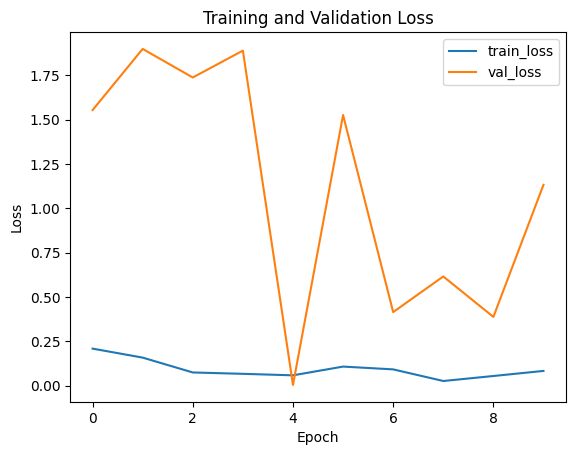

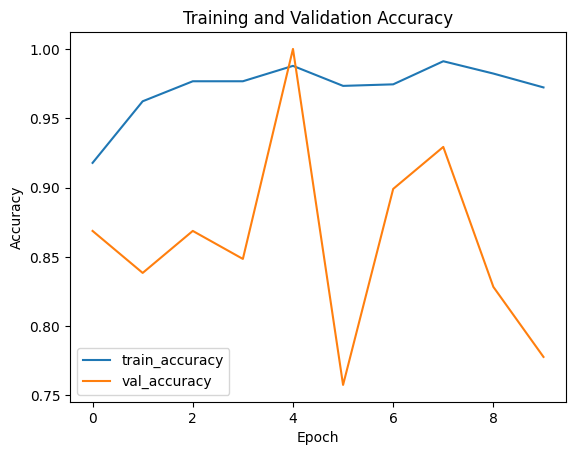

In [ ]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Create New Model
model = load_model('model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2) 차원수

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

1/1 [==============================] - 0s 37ms/step


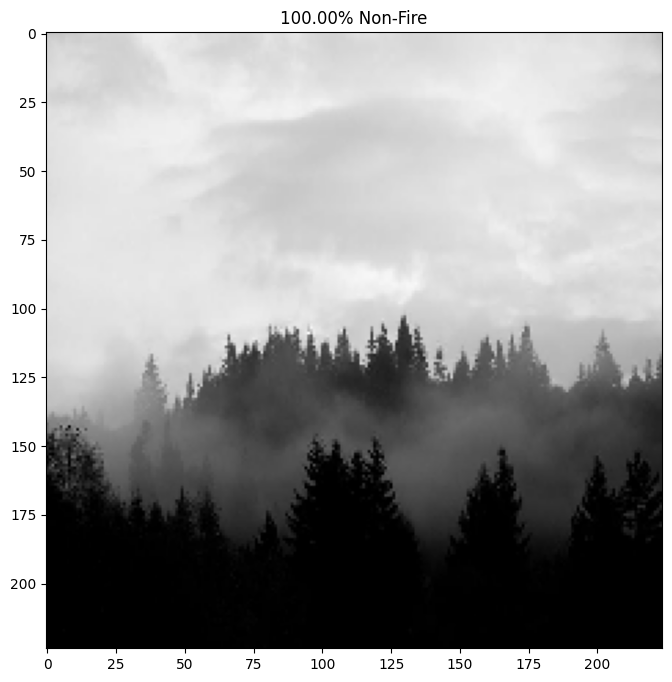

In [ ]:
# Normal Prediction
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/non_fire.1.png'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Non-Fire' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

1/1 [==============================] - 0s 38ms/step


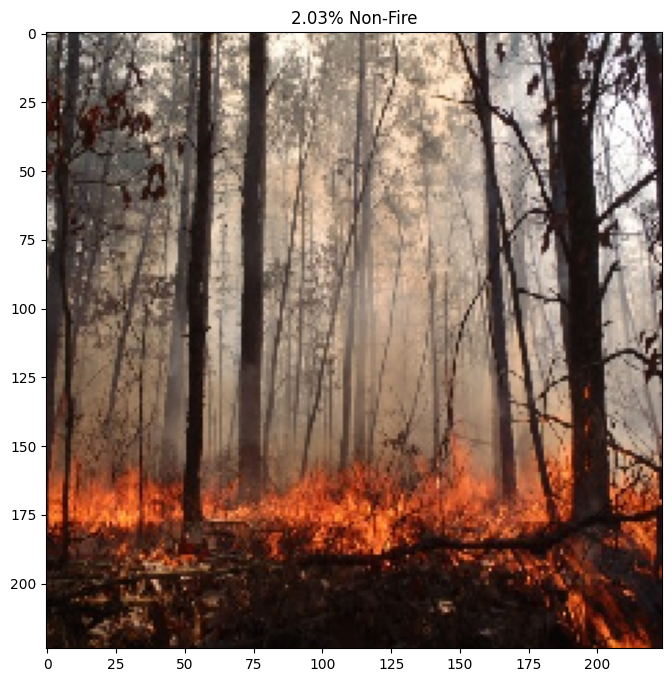

In [ ]:
# Normal Prediction
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Full/fire.10.png'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Non-Fire' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

1/1 [==============================] - 0s 21ms/step


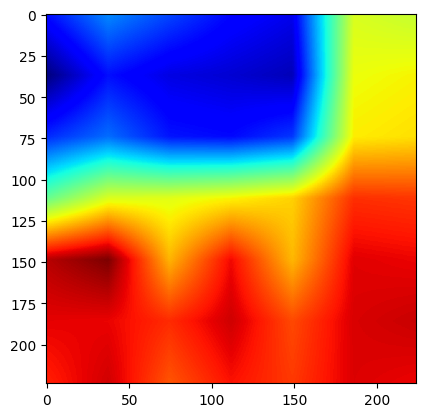

In [ ]:
# Draw Activation Map
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) GAP 전
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1) # GAP 생략

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

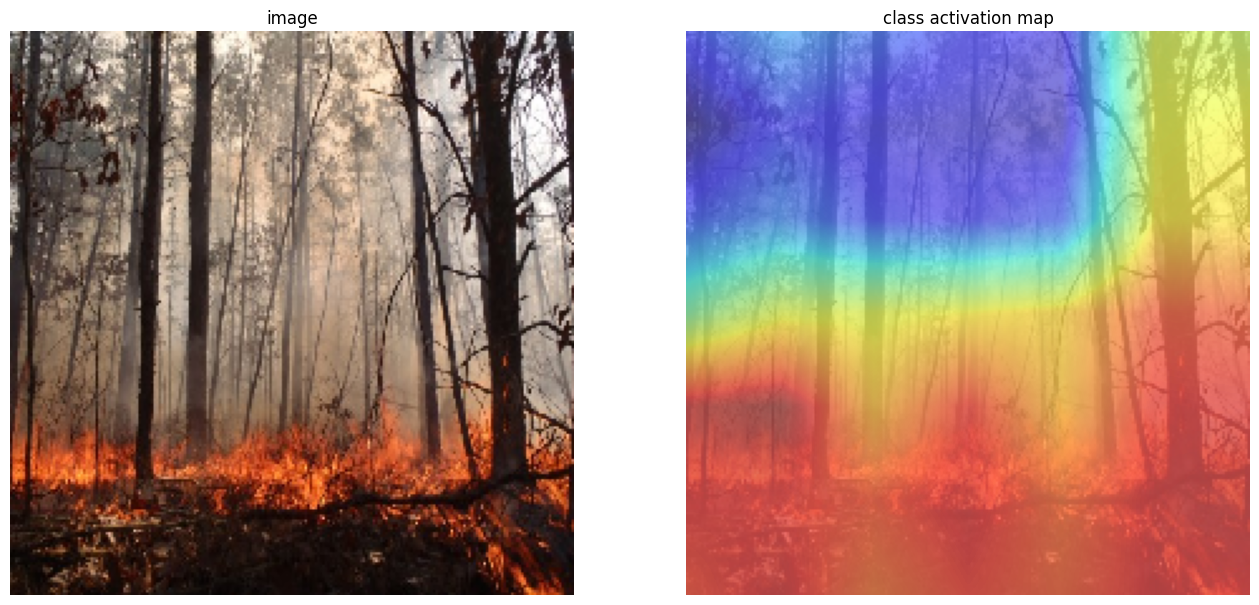

In [ ]:
# result
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()